You can find this code on my GitHub account: https://github.com/MaximilianJHuber/NYU

Question 1
==
I found the following Bellman equation (modulo arithmatic mistakes!):
$$(1-\beta)V_0=\frac{\beta \lambda}{1-\beta(1-\delta)}\left(\frac{1-(1-\beta)^2 V_0^2}{2}-(1-(1-\beta)V_0)V_0 \right)$$

1.6
--

In [1]:
using PyPlot
using Roots
λ=0.5; δ=0.05; β=0.8;

In [18]:
function Vforward(Vn)
    return 1/(1-β)*(β*λ)/(1-β*(1-δ))*( (1-(1-β)^2*Vn.^2)/2 - (1-(1-β).*Vn).*Vn )
    #return 1/( 1-β+(β*λ)/(1-β*(1-δ)) )*(β*λ)/(1-β*(1-δ))*( (1-(1-β)^2*Vn.^2)/2 - ((1-β).*Vn).*Vn )
end

Vforward (generic function with 1 method)

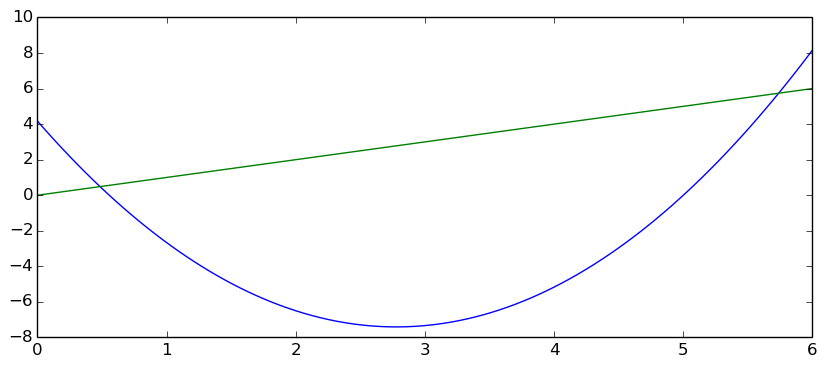

In [19]:
grid = collect(linspace(0,6,100))
figure(figsize=(10,4))
plot(grid, Vforward(grid))
plot(grid, grid);

The two roots are at:

In [21]:
V = [fzero(v->Vforward(v)-v,0,1), fzero(v->Vforward(v)-v,5,6)]

2-element Array{Float64,1}:
 0.484091
 5.73813 

But only the first one leads to a sensible cutoff rule:

In [22]:
W=V.*(1-β)

2-element Array{Float64,1}:
 0.0968182
 1.14763  

A worker who is forever stuck earning zero wage has a lower value (0) than an unemployed worker who will get a positive wage with positive probability in the future.

In [23]:
function iterate(f::Function; tol=1e-4, init=0.0)|
    err = 1
    V_old = init
    V_new = 0.0
    while err > tol
        V_new = f(V_old)[1]
        err = abs(V_old-V_new)
        V_old = V_new
    end
    return V_new
end

iterate (generic function with 1 method)

In [24]:
iterate(Vforward, init=0.0)

NaN

The algorithm does not converge, but that is not surprising if we follow the first few iterations:
$$(0, 4.16, -4.51, 72.34, 7252.03)$$
Even starting very close does not give convergence.

A worker who is stuck with wage one for life has a value of $\frac{1}{1-\beta}$.

In [9]:
iterate(Vforward, init=1/(1-β))

0.41294771551324916

No convergence here! Seems a bit fishy.

Question 3
==

Let's recycle code used from the vectorization task and from the simple shock task in the last problem set. States are capital (endogenous) and total factor productivity (exogenous), control will be next periods capital. Therefore, interpolation will not be necessary.

3.1
--
I use automatic differentiation for steady state calculation (see, http://www.juliadiff.org/).

In [1]:
using Roots #for finding the steady state
using ForwardDiff #for constructing the Euler equation automatically
using PyPlot
using QuantEcon

type GrowthModelShock
    β::Float64
    α::Float64
    A::Float64
    γ::Float64
    δ::Float64
    f::Function
    u::Function
    lom::Function
    kk2c::Function
    invest::Function
    k_grid_min::Float64
    k_grid_max::Float64
    k_grid_size::Int
    k_grid::LinSpace{Float64}
    k_stst::Float64
    z_grid_size::Int
    z_MC::MarkovChain
    
    F::Function
end

function GrowthModelShock(k_grid_min, k_grid_max; k_grid_size=100, z_grid_size=21, z_ρ=0.95, z_σ=0.02, 
    f=(k,z) -> A.*(exp(z)).*k.^α, u=c->(c.^(1-γ)-1)/(1-γ), lom=(k,z,c)->(1-δ)*k + f(k,z) .- c,
    kk2c=(k,z,kprime)->(1-δ)*k + f(k,z) .- kprime, invest=(k,kprime) -> kprime - k, β=0.98, α=1/3, A=1, γ=2, δ=0.05)

    F(k::Vector) = u(kk2c(k[1], k[2], k[3]))
    eulersteady(k) = reshape(ForwardDiff.gradient(F,[k,0,k])' * [β,0,1], 1)[1] #F evaulated with z=0!
    k_stst = fzero(eulersteady, 0.5, 60)
    
    k_grid = linspace(k_stst*k_grid_min, k_stst*k_grid_max, k_grid_size)
    
    z_MC = rouwenhorst(z_grid_size,z_ρ,z_σ*sqrt(1-z_ρ^2))
    
    return GrowthModelShock(β,α,A,γ,δ,f,u,lom,kk2c,invest,k_grid_min,
        k_grid_max,k_grid_size,k_grid,k_stst,z_grid_size,z_MC,F)
end

GrowthModelShock

In [2]:
m = GrowthModelShock(0.5,1.5,k_grid_size=100);
m.k_stst

10.301099814055606

3.2
--
Let's solve the model!

In [3]:
function myVFIshock(m::GrowthModelShock; threshold=1e-4, max_iter=1000)
    
    V_old = zeros(m.k_grid_size,m.z_grid_size)    #old continuation value; rows = capital, cols = TFP shock
    V_next = Array(Float64, m.k_grid_size,m.z_grid_size)   #new value function
    policy = Array(Int64, m.k_grid_size,m.z_grid_size)     #grid index of optimal choice, that will be capital!
    c_policy = Array(Float64, m.k_grid_size,m.z_grid_size)   #consumption
    i_policy = Array(Float64, m.k_grid_size,m.z_grid_size)   #net investment
    V_cont = Array(Float64,m.k_grid_size,m.z_grid_size)    #expected continuation value; rows = capital, cols = TFP shock
    
    F_mat = Array(Float64,m.k_grid_size,m.k_grid_size,m.z_grid_size)  #rows: choices, cols: capital, aisles: TFP shock
    V_try = Array(Float64,m.k_grid_size,m.k_grid_size) #rows: choices, cols: capital
    
    #prepare the reward function F(k',k,z)
    #its values stay constant in the course of the iteration
    for (i,y) in enumerate(m.k_grid) #control    
        for (j,k) in enumerate(m.k_grid) #capital
            for (h,z) in enumerate(m.z_MC.state_values)
                F_mat[i,j,h] = m.kk2c(k, z, y) >= 0 ? m.F([k, z, y]) : -Inf
            end
        end
    end
    
    t = 0
    err = 1.
        
    while err>=threshold && t <= max_iter
        t += 1
        
        V_cont = V_old * m.z_MC.p' #expected continuation value given rows = capital and cols = current TFP shock

        # iterate over current TFP shock
        for (h,z) in enumerate(m.z_MC.state_values) 
            
            #assemble choices in rows, current capital in column
            V_try = F_mat[:,:,h] + m.β*hcat([V_cont[:,h] for j=1:m.k_grid_size]...)
        
            for (i,k) in enumerate(m.k_grid) #capital
                policy[i,h] = indmax(V_try[:,i])
                V_next[i,h] = V_try[policy[i,h],i]
                c_policy[i,h] = m.kk2c(k,z,m.k_grid[policy[i,h]])
                i_policy[i,h] = m.invest(k,m.k_grid[policy[i,h]])
            end
        end
        
        err = maxabs(V_next .- V_old)
        V_old = copy(V_next)
    end
    
    if err>=threshold 
        warn("not converged!")
    end
    
    return (V_next, policy, c_policy, i_policy, t)
end

myVFIshock (generic function with 1 method)

In [15]:
@time (V_next, policy, c_policy, i_policy, t) = myVFIshock(m);

  6.585515 seconds (29.57 M allocations: 4.530 GB, 12.81% gc time)


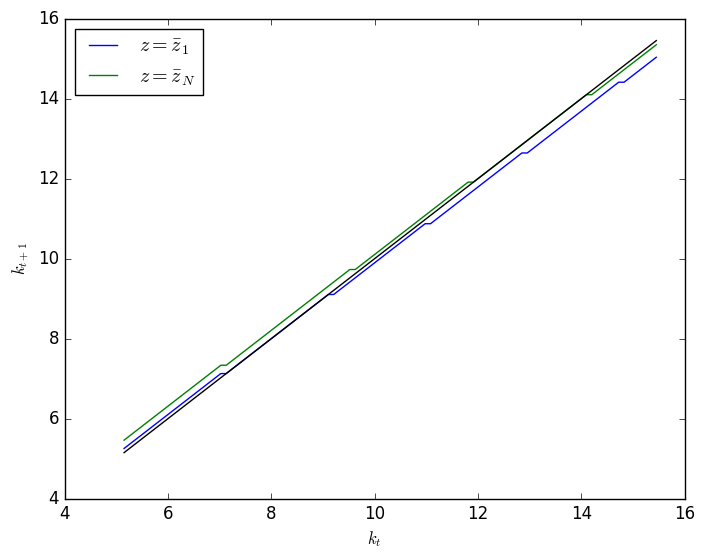

In [5]:
plot(m.k_grid,m.k_grid[policy[:,1]], label=L"$z=\bar{z}_1$")
plot(m.k_grid,m.k_grid[policy[:,21]], label=L"$z=\bar{z}_N$")
plot(m.k_grid,m.k_grid, color="k")
xlabel(L"$k_{t}$")
ylabel(L"$k_{t+1}$")
legend(loc="upper left");

Next period's capital is increasing in current TFP shock! The intertemporal trade off between consumption today and consumption tomorrow is tilted in favour of saving because of the persistence of the TFP shock.
The capital will never exceed 15.

3.3
--
I write a simulation function that can produce more than one path simultaneously.

In [6]:
function simulateShock(m::GrowthModelShock, policy; paths=1, len=11000, trim=1000, impulse=false, kinit=0)
    z_paths = Array(Int, len, paths) #matrix where each column is a different trajectory of the same Markov chain 
    simulate_indices!(z_paths, m.z_MC, init = impulse ? ones(Int,paths)*n_states(m.z_MC) : rand(1:n_states(m.z_MC),paths))
    
    K = Array(Int64,len,paths)
    K[1,:] = impulse ? ones(paths)*k0 : rand(1:m.k_grid_size,paths) #randomize initial capital
    
    for t in 2:len
        K[t,:] = policy[K[t-1,:].+(z_paths[t-1,:]-1).*m.k_grid_size]
    end
    
    return (K[trim+1:end,:],z_paths[trim+1:end,:])
end

simulateShock (generic function with 1 method)

In [7]:
(k_paths,z_paths) = simulateShock(m,policy);

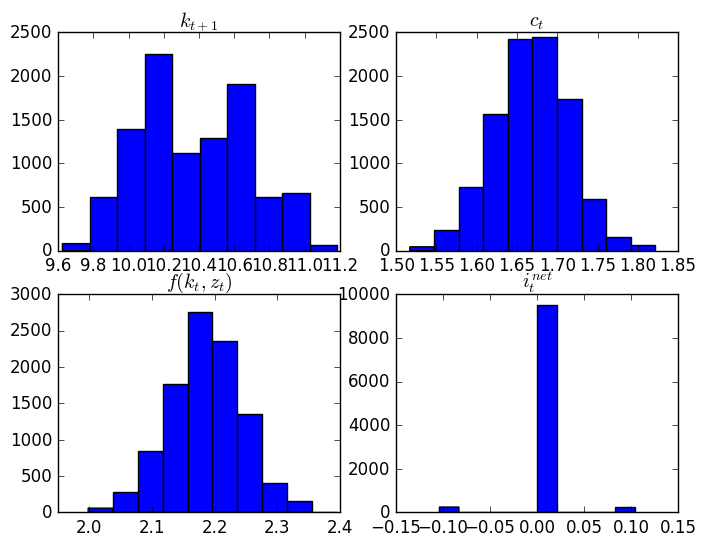

In [8]:
subplot(221)
PyPlot.plt[:hist](m.k_grid[k_paths[:,1]]);
title(L"k_{t+1}")
subplot(222)
PyPlot.plt[:hist](c_policy[k_paths[:,1] .+ (z_paths[:,1]-1).*m.k_grid_size]);
title(L"c_{t}")
subplot(223)
PyPlot.plt[:hist](m.f(m.k_grid[k_paths[:,1]],m.z_MC.state_values[z_paths[:,1]]));
title(L"f(k_t,z_t)")
subplot(224)
PyPlot.plt[:hist](i_policy[k_paths[:,1] .+ (z_paths[:,1]-1).*m.k_grid_size]);
title(L"i_{t}^{net}");

3.4
--

In [9]:
k_tilde = mean(m.k_grid[k_paths[:,1]])
k_tilde - m.k_stst

0.05873707924277305

Yes, the long-run average capital is quite close to the steady state level!
But, the steady state capital is calculated for the deterministic world. The more uncertainty there is, the higher the average long-run capital.

In [10]:
σ_m = GrowthModelShock(0.5,1.5,k_grid_size=100, z_σ=0.2)
(σ_V_next, σ_policy, σ_c_policy, σ_i_policy, σ_t) = myVFIshock(σ_m)
(σ_k_paths,σ_z_paths) = simulateShock(σ_m,σ_policy)
mean(σ_m.k_grid[σ_k_paths[:,1]]) - σ_m.k_stst

0.6239761147972622

3.5
--

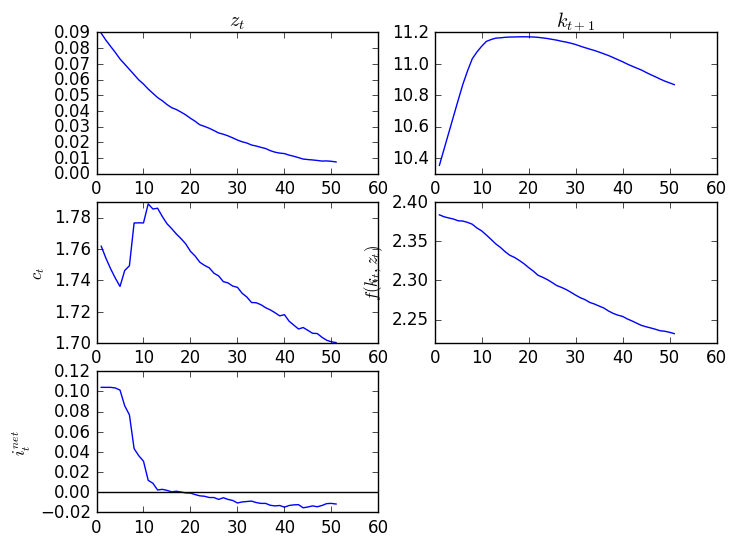

In [14]:
k0 = indmin(abs(k_tilde .- m.k_grid))
(k_paths,z_paths) = simulateShock(m, policy, paths=500,len=51, trim=0, impulse=true, kinit=k0)
subplot(321)
plot(1:51,[mean(m.z_MC.state_values[z_paths[t,:]]) for t in 1:51])
title(L"z_{t}")
subplot(322)
plot(1:51,[mean(m.k_grid[k_paths[t,:]]) for t in 1:51])
title(L"k_{t+1}")
subplot(323)
plot(1:51,[mean(c_policy[k_paths[t,:] .+ (z_paths[t,:]-1).*m.k_grid_size]) for t in 1:51])
ylabel(L"c_{t}")
subplot(324)
plot(1:51,[mean(m.f(m.k_grid[k_paths[t,:]],m.z_MC.state_values[z_paths[t,:]])) for t in 1:51])
ylabel(L"f(k_t,z_t)")
subplot(325)
plot(1:51,[mean(i_policy[k_paths[t,:] .+ (z_paths[t,:]-1).*m.k_grid_size]) for t in 1:51])
axhline(0,color="k")
ylabel(L"i_{t}^{net}");

3.6
--